In [1]:
import json
import pandas as pd
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
from itertools import chain, repeat
%matplotlib inline

### Part 1: Data Analyst

1. The attached logins.json file contains (simulated) timestamps of user logins in a
particular geographic location. Aggregate these login counts based on 15-minute time
intervals, and visualize and describe the resulting time series of login counts in ways that
best characterize the underlying patterns of the demand. Please report/illustrate
important features of the demand, such as daily cycles. If there are data quality issues,
please report them. We’re looking for people who can “tell the data story:” use empirical
evidence to make product decisions and develop effective decision systems.

#### Step 1: Load json data and create pandas dataframe

In [2]:
json_data=open('logins2.json').read()
data = json.loads(json_data)

In [3]:
data.keys()

dict_keys(['login_time'])

In [4]:
data_pairs = list(zip([i.split()[0] for i in data['login_time']],[i.split()[1] for i in data['login_time']]))
df = pd.DataFrame(data_pairs,columns=['Date','Time'])

In [5]:
#check if there is missing rows when creating dataframe
len(data['login_time']) == len(df)

True

In [6]:
df.head()

,Date,Time
0,2010-01-01,00:11:52
1,2010-01-01,00:13:00
2,2010-01-01,00:14:49
3,2010-01-01,00:21:00
4,2010-01-01,00:23:05


In [7]:
df.duplicated().any()

False

#### Step 2: Data clean and transformation

In [74]:
range_15_min = pd.date_range("00:00", "23:59", freq="15min").strftime('%H:%M:%S')

In [77]:
#create 15min interval 
interval_15_min = []
for i in range(len(range_15_min)-1):
    interval_15_min.append((range_15_min[i],range_15_min[i+1]))
interval_15_min.append((range_15_min[-1],'23:59:59'))

In [10]:
def string_to_time(s):
    return datetime.datetime.strptime(s, '%H:%M:%S').time()

In [11]:
def string_to_date(s):
    return datetime.datetime.strptime(s, '%Y-%m-%d').date()

In [88]:
#given a login time, return the 15min interval
def calculate_login_interval(login_time,interval_list):
    login = string_to_time(login_time)
    if login != string_to_time('00:00:00'):
        for range_ in interval_list:
            low = string_to_time(range_[0])
            high = string_to_time(range_[1])
            if login > low and login <= high:
                return range_
    else:
        return interval_list[0]

In [89]:
df['15_min_interval'] = df['Time'].apply(lambda x:calculate_login_interval(x,interval_15_min))

In [91]:
df.head()

,Date,Time,15_min_interval,Day_of_Week,Month
0,2010-01-01,00:11:52,"(00:00:00, 00:15:00)",4,1
1,2010-01-01,00:13:00,"(00:00:00, 00:15:00)",4,1
2,2010-01-01,00:14:49,"(00:00:00, 00:15:00)",4,1
3,2010-01-01,00:21:00,"(00:15:00, 00:30:00)",4,1
4,2010-01-01,00:23:05,"(00:15:00, 00:30:00)",4,1


In [14]:
#Monday is 0; Sunday is 6
df['Day_of_Week'] = df['Date'].apply(lambda x: string_to_date(x).weekday())

In [15]:
#Get the month number to check seasonality
df['Month'] = df['Date'].apply(lambda x:string_to_date(x).month)

#### Step 3: Visualization

Daily Trend

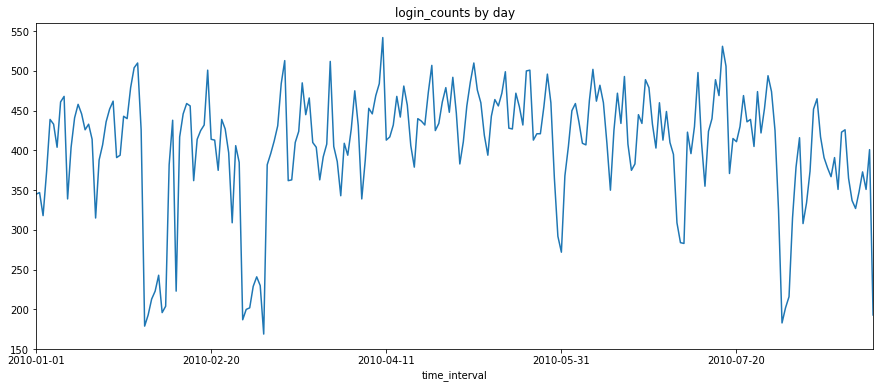

In [92]:
df_by_day = df['Date'].value_counts().rename_axis('time_interval').sort_index()
df_by_day.plot(figsize=(15, 6),title="login_counts by day")

In [93]:
#delete data points on 2010-08-28
df2 = df[df['Date'] != '2010-08-28']

Weekly Trend

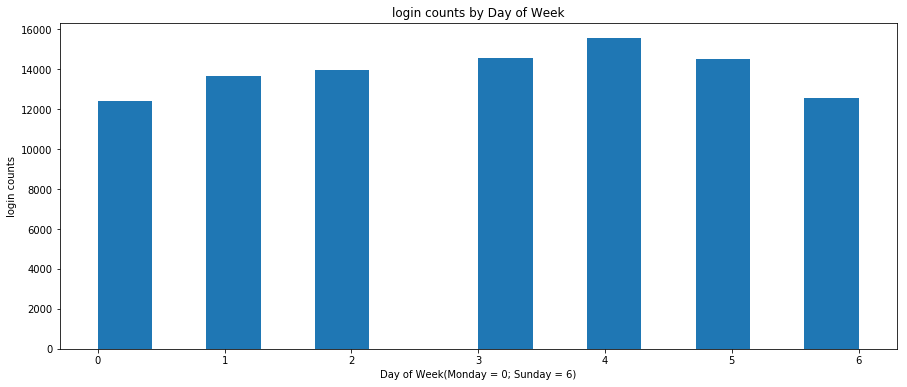

In [94]:
df2['Day_of_Week'].hist(bins=14,figsize=(15, 6))
plt.title('login counts by Day of Week')
plt.ylabel("login counts")
plt.xlabel("Day of Week(Monday = 0; Sunday = 6)")
plt.grid(False)


In [95]:
df2['Day_of_Week'].value_counts().rename_axis('Day_of_Week').reset_index(name='count').to_csv(r'day_of_week.csv',index=False)

Monthly Trend

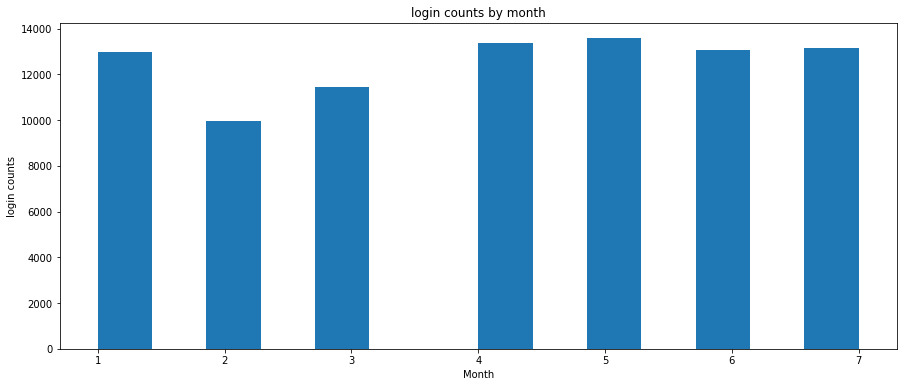

In [96]:
df2[df2['Month'] != 8]['Month'].hist(bins=14,figsize=(15, 6))
plt.title('login counts by month')
plt.ylabel("login counts")
plt.xlabel("Month")
plt.grid(False)

15-min interval plot

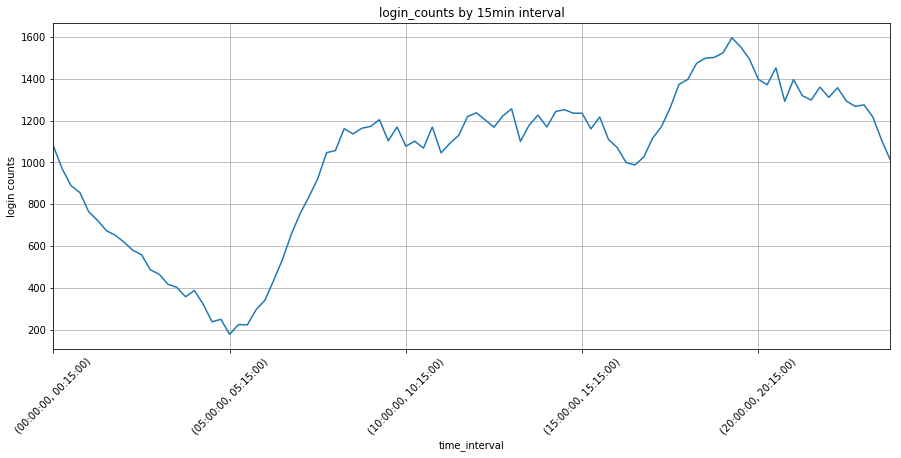

In [97]:
df_vis = df2['15_min_interval'].value_counts().rename_axis('time_interval').sort_index()
df_vis.plot(figsize=(15, 6),title="login_counts by 15min interval")
plt.ylabel("login counts")
plt.xticks(rotation=45)
plt.grid(True)

Replace the irregular points with the average number

In [98]:
irregular_points = ['2010-02-01','2010-02-02','2010-02-03','2010-02-04','2010-02-05','2010-02-06','2010-03-01',
                    '2010-03-02','2010-03-03','2010-03-04','2010-03-05','2010-03-06','2010-03-07','2010-05-30',
                    '2010-05-31','2010-06-01','2010-06-02','2010-07-03','2010-07-04','2010-07-05','2010-08-02',
                    '2010-08-03','2010-08-04']

In [229]:
dff = df2[~df2['Date'].isin(irregular_points)]['15_min_interval'].value_counts().rename_axis('15_min_interval').sort_index().reset_index(name='count')
dff['mean'] = dff['count'].apply(lambda x: round(x/len(df2['Date'].unique())))

In [261]:
dff.head()

,15_min_interval,count,mean
0,"(00:00:00, 00:15:00)",1013,4
1,"(00:15:00, 00:30:00)",921,4
2,"(00:30:00, 00:45:00)",831,3
3,"(00:45:00, 01:00:00)",798,3
4,"(01:00:00, 01:15:00)",722,3


In [237]:
df3 = df2[~df2['Date'].isin(irregular_points)].groupby(['Date','15_min_interval']).count().reset_index().rename(columns={'Time':'Count'})[['Date','15_min_interval','Count']]

In [235]:
replace_df = pd.DataFrame(OrderedDict({'Date':list(chain.from_iterable(zip(*repeat(irregular_points, len(dff))))), '15_min_interval': list(dff['15_min_interval']) * len(irregular_points),'Count':list(dff['mean']) * len(irregular_points)}))

In [390]:
df4 = df3.append(replace_df).sort_values(by=['Date','15_min_interval'])

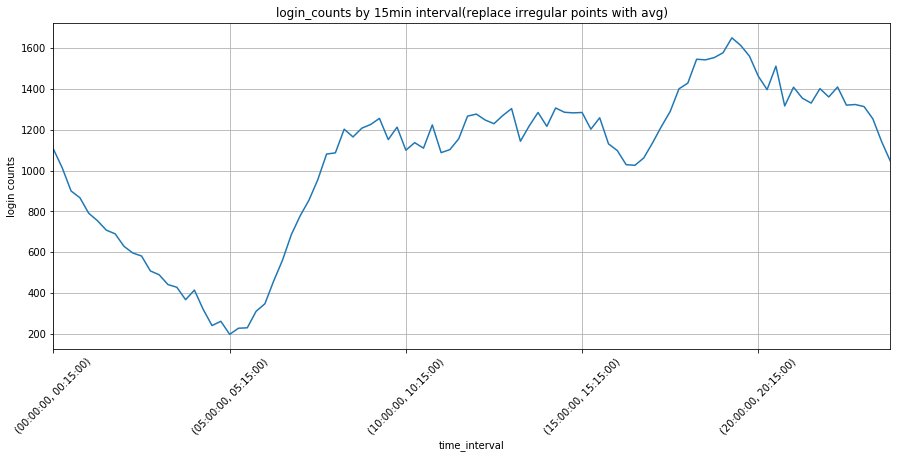

In [391]:
df_vis_2 = df4.groupby(['15_min_interval'])['Count'].sum().rename_axis('time_interval').sort_index()
df_vis_2.plot(figsize=(15, 6),title="login_counts by 15min interval(replace irregular points with avg)")
plt.ylabel("login counts")
plt.xticks(rotation=45)
plt.grid(True)

In [392]:
df4['Month'] = df4['Date'].apply(lambda x:string_to_date(x).month)

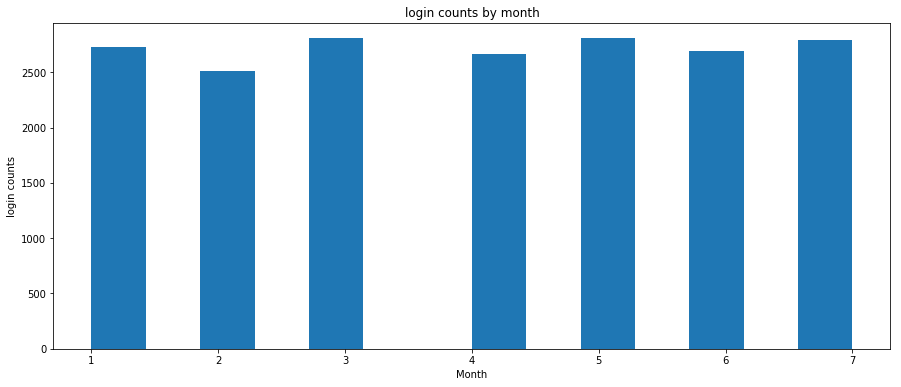

In [393]:
df4[df4['Month'] != 8]['Month'].hist(bins=14,figsize=(15, 6))
plt.title('login counts by month')
plt.ylabel("login counts")
plt.xlabel("Month")
plt.grid(False)

After replacing the irregular points with the average, we could see that, Feb and March total logins are much close to the other months. 

#### Step 3: Feature Engineering

To generate more features, I added the following features based on the insights from the previous data analysis:
1. 15_min_interval_count: which 15-min interval is the current time, starting from 00:00 midnight.
2. Morning_Rush_Hour: binary feature indicating if the current time is in the morning rush hours or not (5:00 AM - 9:30 AM).
3. Evening_Rush_Hour: binary feature indicating if the current time is in the evening rush hours or not (4:00 PM - 8:00 PM).

A general idea for modeling is to separate the time periods into 5 models:
1. Between 00:00 to 5:00 AM, a linear regression model is used when the demand is decreasing linearly
2. Between 5:00 AM to 9:30 AM, a second linear regression model is used when the demand is increasing linearly
3. Between 9:30 AM to 4:00 PM, the demand is bounded by some values.
4. From 4:00 PM to 8:00 PM, a third linear regression model is used when demand is increasing during the evening rush hour.
5. From 8:00 PM to 24:00, the last linear regression model is used when demand is decreasing again.

In [342]:
#given a login time, return the 15min interval
def calculate_login_interval_count(login_time):
    login = string_to_time(login_time)
    return login_time - datetime()

def morning_rush_hour(time_interval):
    low = string_to_time(time_interval[0])
    high= string_to_time(time_interval[1])
    if low >= string_to_time('05:00:00') and high <= string_to_time('09:30:00'):
        return 1
    else:
        return 0
    
def evening_rush_hour(time_interval):
    low = string_to_time(time_interval[0])
    high= string_to_time(time_interval[1])
    if low >= string_to_time('16:00:00') and high <= string_to_time('20:00:00'):
        return 1
    else:
        return 0

def first_linear(time_interval):
    low = string_to_time(time_interval[0])
    high= string_to_time(time_interval[1])
    if low >= string_to_time('00:00:00') and high <= string_to_time('05:00:00'):
        return 1
    else:
        return 0
    
def third_model(time_interval):
    low = string_to_time(time_interval[0])
    high= string_to_time(time_interval[1])
    if low >= string_to_time('09:30:00') and high <= string_to_time('16:00:00'):
        return 1
    else:
        return 0

def last_model(time_interval):
    low = string_to_time(time_interval[0])
    high= string_to_time(time_interval[1])
    if low >= string_to_time('20:00:00') and high <= string_to_time('23:59:59'):
        return 1
    else:
        return 0

In [394]:
df4['15_min_interval_count'] = df4['15_min_interval'].apply(lambda x: interval_15_min.index(x)+1)

In [395]:
df4['Morning_Rush_Hour'] = df4['15_min_interval'].apply(lambda x: morning_rush_hour(x))
df4['Evening_Rush_Hour'] = df4['15_min_interval'].apply(lambda x: evening_rush_hour(x))
df4['first_linear'] = df4['15_min_interval'].apply(lambda x: first_linear(x))
df4['third_model'] = df4['15_min_interval'].apply(lambda x: third_model(x))
df4['last_model'] = df4['15_min_interval'].apply(lambda x: last_model(x))

#### Step 4: Split Train/Test

Becuase we assume there is no big difference among different months, I am going to split the train and test dataset by using Jan, Feb, March, April and May data as training dataset, June and July data as test set. 

In [452]:
train_month = [1,2,3,4,5]
test_month = [6,7]
train = df4[df4['Month'].isin(train_month)].groupby(['15_min_interval','15_min_interval_count','Morning_Rush_Hour','Evening_Rush_Hour','first_linear','third_model','last_model'])['Count'].sum().reset_index()
test = df4[df4['Month'].isin(test_month)].groupby(['15_min_interval','15_min_interval_count','Morning_Rush_Hour','Evening_Rush_Hour','first_linear','third_model','last_model'])['Count'].sum().reset_index()

#### Step 5: Modeling

In [347]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from random import randint

In [346]:
X_train = train[['15_min_interval_count','Morning_Rush_Hour','Evening_Rush_Hour','first_linear','third_model','last_model']]
y_train = train['Count']

X_test = test[['15_min_interval_count','Morning_Rush_Hour','Evening_Rush_Hour','first_linear','third_model','last_model']]
y_test = test['Count']

In [576]:
model_order = ['first_linear','Morning_Rush_Hour','third_model','Evening_Rush_Hour','last_model']
def build_models(method):
    y_pred = []
    y_true = []
    adjust_value = len(test_month)/len(train_month)
    
    for item in model_order:
        X_train = train[train[item] == 1][['15_min_interval_count']]
        y_train = train[train[item] == 1]['Count']
        X_test = test[test[item] == 1][['15_min_interval_count']]
        y_test = test[test[item] == 1]['Count']
        
        #except for the 3rd model, all other models are linear regression models
        if item != 'third_model':
            # Create linear regression object
            regr = linear_model.LinearRegression()
            # Train the model using the training sets
            regr.fit(X_train,y_train)
            # Make predictions using the testing set
            y_pred.extend(regr.predict(X_test) * adjust_value)
            y_true.extend(y_test)
        #the third model is a bounded distribution by maximum and minimum demand within this period
        else:
            if method == 'random':
                maxi = int(y_train.max() * adjust_value)
                mini = int(y_train.min() * adjust_value)
                prediction = [randint(mini, maxi) for i in range(len(y_test))]
            if method == 'median':
                prediction = [y_train.median() * adjust_value] * len(y_test) 
            if method == "mean":
                prediction = [y_train.mean() * adjust_value] * len(y_test)
                
            y_pred.extend(prediction)
            y_true.extend(y_test)
    return y_true, y_pred
            
            


#### Step 6: Evaluate Model

To evaluate the model, i calculated every four 15-min interval(1 hour) prediction, and use the mean-square as the evaluation metric. For example, starting from 00:00, given the demand on 00:00 which is 220, the prediction in the following 1 hour is [200,190,180,170] and the true demand is [215,200,198,180], so the mean square error will be sum(215 - 200 + 200 - 190 + 298 - 180 + 180 - 170) ** 2

In [607]:
def evaluate_model(true,pred):
    total_error = 0
    for i in range(1,len(true)-3):
        diff = np.sum(true[i:i+4]) - np.sum(pred[i:i+4])
        total_error += diff ** 2
    return total_error/(len(true)-3)

In [608]:
method_list = ["random","median","mean"]
error_list = []
for method in method_list:
    true = build_models(method)[0]
    pred = build_models(method)[1]
    error_list.append(evaluate_model(true,pred))


In [609]:
error_list

[7532.1354805583042, 5415.1617562517549, 5705.5106260836719]

In [605]:
method_list = ["random","median","mean"]
error_list_new = []
for method in method_list:
    true = build_models(method)[0]
    pred = build_models(method)[1]
    error_list_new.append(mean_squared_error(true,pred))

In [606]:
error_list_new

[927.40817101577397, 630.20858768244079, 646.89781845167147]

### Part 2: Programming

Say we have a set of cuisines, each of which can be represented by a letter of the alphabet, and
a set of dishes within each cuisine, each of which can be represented by a number. Each
cuisine has a different number of possible dishes available. Note: this exercise needs to be
completed without the use of library functions that perform the enumeration.
A menu consists of a set of dishes chosen from the different cuisines. A menu can be
represented by a list of dishes such as “A3 B11 C4”. Assume that each menu contains exactly
one dish from each cuisine and all cuisines are included. Write a program that takes the number
of cuisines and the number of dishes available within each cuisine as input and lists all possible
menus as output.

In [32]:
import string
import numpy as np
import math
import random
import itertools

def menus(n_cuisin,n_dish):
    #first check the inputs type
    if type(n_cuisin) != int or type(n_dish) != list:
        return "Inputs have to be an integer and a list"
    else:
        #check if inputs are empty
        if len(n_dish) == 0:
            return "Cannot take empty list as input"
        else:
            #n_cuisin has to be positive integer
            if n_cuisin <= 0 or n_cuisin > 26:
                return "Number of cuisines has to be positive integer less or equal to 26"
            #n_dish has to be list of integers
            if all(type(item) == int for item in n_dish) == False:
                return "n_dish has to be a list of integers"
            else:
                #n_dish has to be a list that has the length equal to n_cuisin
                if len(n_dish) != n_cuisin:
                    return "Number of dishes for each cuisin has to be the same as number of cuisin!"
                else:
                    
                    #theoratically calculate total number of available menus
                    available_choices = np.product(n_dish)
                    print("There are {} possible menus:".format(int(available_choices)))
                    
                    #using alphet to represent each cuisin by alphet order
                    cuisin_list = list(string.ascii_uppercase)[:n_cuisin]
                    dish_comb = [[i for i in range(1,k+1)] for k in n_dish]

                    menu_comb = []
                    for c in cuisin_list:
                        ix = cuisin_list.index(c)
                        single_cuisin_comb = ["".join(map(str,[c,n])) for n in dish_comb[ix]]   
                        menu_comb.append(single_cuisin_comb)  
                    
                    count = 0
                    for m in list(itertools.product(*menu_comb)): 
                        print(m)
                        count += 1
                    #check if theoratically result is equal to the function calculation
                    assert count == available_choices, "Please check your function"
                    
                
                    
                    
                    
                
                

In [34]:
menus(5,[1,2,2])

'Number of dishes for each cuisin has to be the same as number of cuisin!'

In [35]:
menus(5,[2,5,2,3,5])

There are 300 possible menus:
('A1', 'B1', 'C1', 'D1', 'E1')
('A1', 'B1', 'C1', 'D1', 'E2')
('A1', 'B1', 'C1', 'D1', 'E3')
('A1', 'B1', 'C1', 'D1', 'E4')
('A1', 'B1', 'C1', 'D1', 'E5')
('A1', 'B1', 'C1', 'D2', 'E1')
('A1', 'B1', 'C1', 'D2', 'E2')
('A1', 'B1', 'C1', 'D2', 'E3')
('A1', 'B1', 'C1', 'D2', 'E4')
('A1', 'B1', 'C1', 'D2', 'E5')
('A1', 'B1', 'C1', 'D3', 'E1')
('A1', 'B1', 'C1', 'D3', 'E2')
('A1', 'B1', 'C1', 'D3', 'E3')
('A1', 'B1', 'C1', 'D3', 'E4')
('A1', 'B1', 'C1', 'D3', 'E5')
('A1', 'B1', 'C2', 'D1', 'E1')
('A1', 'B1', 'C2', 'D1', 'E2')
('A1', 'B1', 'C2', 'D1', 'E3')
('A1', 'B1', 'C2', 'D1', 'E4')
('A1', 'B1', 'C2', 'D1', 'E5')
('A1', 'B1', 'C2', 'D2', 'E1')
('A1', 'B1', 'C2', 'D2', 'E2')
('A1', 'B1', 'C2', 'D2', 'E3')
('A1', 'B1', 'C2', 'D2', 'E4')
('A1', 'B1', 'C2', 'D2', 'E5')
('A1', 'B1', 'C2', 'D3', 'E1')
('A1', 'B1', 'C2', 'D3', 'E2')
('A1', 'B1', 'C2', 'D3', 'E3')
('A1', 'B1', 'C2', 'D3', 'E4')
('A1', 'B1', 'C2', 'D3', 'E5')
('A1', 'B2', 'C1', 'D1', 'E1')
('A1', 'B